In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "40X"
trainable_blocks = ["block3", "block4"]
irun = 1


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_40X-BREAKHIS-Dataset-60-10-30-VGGINet/1'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/40X/1'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1077 files belonging to 2 classes.


Found 179 files belonging to 2 classes.


Found 539 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0594 - accuracy: 0.5859

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 6s - loss: 4.1341 - accuracy: 0.6758

3/9 [=========>....................] - ETA: 9s - loss: 4.1859 - accuracy: 0.6745

4/9 [============>.................] - ETA: 8s - loss: 3.8431 - accuracy: 0.6895

5/9 [===============>..............] - ETA: 7s - loss: 3.7244 - accuracy: 0.6922

6/9 [===================>..........] - ETA: 5s - loss: 3.4333 - accuracy: 0.7031

7/9 [======================>.......] - ETA: 3s - loss: 3.2159 - accuracy: 0.7266

8/9 [=========================>....] - ETA: 1s - loss: 3.1246 - accuracy: 0.7441

9/9 [==============================] - ETA: 0s - loss: 3.1907 - accuracy: 0.7428

9/9 [==============================] - 25s 3s/step - loss: 3.1907 - accuracy: 0.7428 - val_loss: 6.8497 - val_accuracy: 0.8659


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 3.0431 - accuracy: 0.8516

2/9 [=====>........................] - ETA: 13s - loss: 2.5870 - accuracy: 0.8672

3/9 [=========>....................] - ETA: 9s - loss: 2.1832 - accuracy: 0.8698 

4/9 [============>.................] - ETA: 9s - loss: 2.4817 - accuracy: 0.8477

5/9 [===============>..............] - ETA: 7s - loss: 2.6387 - accuracy: 0.8281

6/9 [===================>..........] - ETA: 5s - loss: 2.5723 - accuracy: 0.8242

7/9 [======================>.......] - ETA: 3s - loss: 2.4449 - accuracy: 0.8270

8/9 [=========================>....] - ETA: 1s - loss: 2.3234 - accuracy: 0.8350

9/9 [==============================] - ETA: 0s - loss: 2.2562 - accuracy: 0.8394

9/9 [==============================] - 16s 2s/step - loss: 2.2562 - accuracy: 0.8394 - val_loss: 8.1660 - val_accuracy: 0.7989


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4360 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 13s - loss: 2.6725 - accuracy: 0.8750

3/9 [=========>....................] - ETA: 9s - loss: 2.6719 - accuracy: 0.8750 

4/9 [============>.................] - ETA: 9s - loss: 2.4105 - accuracy: 0.8828

5/9 [===============>..............] - ETA: 7s - loss: 2.1123 - accuracy: 0.8906

6/9 [===================>..........] - ETA: 5s - loss: 2.0563 - accuracy: 0.8854

7/9 [======================>.......] - ETA: 3s - loss: 2.0620 - accuracy: 0.8850

8/9 [=========================>....] - ETA: 1s - loss: 2.0718 - accuracy: 0.8809

9/9 [==============================] - ETA: 0s - loss: 2.0297 - accuracy: 0.8774

9/9 [==============================] - 16s 2s/step - loss: 2.0297 - accuracy: 0.8774 - val_loss: 5.2469 - val_accuracy: 0.8492


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9323 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 14s - loss: 1.1073 - accuracy: 0.8984

3/9 [=========>....................] - ETA: 10s - loss: 1.0758 - accuracy: 0.8932

4/9 [============>.................] - ETA: 9s - loss: 1.0266 - accuracy: 0.8906 

5/9 [===============>..............] - ETA: 7s - loss: 0.9442 - accuracy: 0.9047

6/9 [===================>..........] - ETA: 4s - loss: 1.0266 - accuracy: 0.9036

7/9 [======================>.......] - ETA: 3s - loss: 1.1965 - accuracy: 0.8962

8/9 [=========================>....] - ETA: 1s - loss: 1.2954 - accuracy: 0.8926

9/9 [==============================] - ETA: 0s - loss: 1.3119 - accuracy: 0.8932

9/9 [==============================] - 16s 2s/step - loss: 1.3119 - accuracy: 0.8932 - val_loss: 3.0649 - val_accuracy: 0.8827


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0036 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 0.9567 - accuracy: 0.8906

3/9 [=========>....................] - ETA: 11s - loss: 0.8593 - accuracy: 0.8984

4/9 [============>.................] - ETA: 9s - loss: 0.8761 - accuracy: 0.8965 

5/9 [===============>..............] - ETA: 7s - loss: 0.9703 - accuracy: 0.8906

6/9 [===================>..........] - ETA: 5s - loss: 1.0947 - accuracy: 0.8880

7/9 [======================>.......] - ETA: 3s - loss: 1.0733 - accuracy: 0.8906

8/9 [=========================>....] - ETA: 1s - loss: 1.1355 - accuracy: 0.8916

9/9 [==============================] - ETA: 0s - loss: 1.1130 - accuracy: 0.8932

9/9 [==============================] - 16s 2s/step - loss: 1.1130 - accuracy: 0.8932 - val_loss: 5.0778 - val_accuracy: 0.8436


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3651 - accuracy: 0.8828

2/9 [=====>........................] - ETA: 13s - loss: 1.2554 - accuracy: 0.8906

3/9 [=========>....................] - ETA: 10s - loss: 1.1279 - accuracy: 0.8958

4/9 [============>.................] - ETA: 9s - loss: 1.1714 - accuracy: 0.8906 

5/9 [===============>..............] - ETA: 7s - loss: 1.0994 - accuracy: 0.8938

6/9 [===================>..........] - ETA: 5s - loss: 1.0503 - accuracy: 0.8997

7/9 [======================>.......] - ETA: 3s - loss: 1.0460 - accuracy: 0.9018

8/9 [=========================>....] - ETA: 1s - loss: 0.9704 - accuracy: 0.9062

9/9 [==============================] - ETA: 0s - loss: 0.9506 - accuracy: 0.9053

9/9 [==============================] - 16s 2s/step - loss: 0.9506 - accuracy: 0.9053 - val_loss: 2.2069 - val_accuracy: 0.9106


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7785 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 14s - loss: 0.9078 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 9s - loss: 0.9458 - accuracy: 0.8984 

4/9 [============>.................] - ETA: 10s - loss: 1.1596 - accuracy: 0.8984

5/9 [===============>..............] - ETA: 7s - loss: 1.0671 - accuracy: 0.9016 

6/9 [===================>..........] - ETA: 5s - loss: 0.9927 - accuracy: 0.9076

7/9 [======================>.......] - ETA: 3s - loss: 0.8871 - accuracy: 0.9152

8/9 [=========================>....] - ETA: 1s - loss: 0.7977 - accuracy: 0.9219

9/9 [==============================] - ETA: 0s - loss: 0.8519 - accuracy: 0.9220

9/9 [==============================] - 16s 2s/step - loss: 0.8519 - accuracy: 0.9220 - val_loss: 2.2883 - val_accuracy: 0.9218


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9442 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 3s - loss: 0.7256 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 7s - loss: 0.8481 - accuracy: 0.9089

4/9 [============>.................] - ETA: 6s - loss: 0.7789 - accuracy: 0.9062

5/9 [===============>..............] - ETA: 7s - loss: 0.8790 - accuracy: 0.9047

6/9 [===================>..........] - ETA: 4s - loss: 0.8548 - accuracy: 0.9076

7/9 [======================>.......] - ETA: 3s - loss: 0.8122 - accuracy: 0.9107

8/9 [=========================>....] - ETA: 1s - loss: 0.7578 - accuracy: 0.9141

9/9 [==============================] - ETA: 0s - loss: 0.7478 - accuracy: 0.9146

9/9 [==============================] - 16s 2s/step - loss: 0.7478 - accuracy: 0.9146 - val_loss: 2.9846 - val_accuracy: 0.9106


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5868 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 10s - loss: 0.5412 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 8s - loss: 1.1017 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 6s - loss: 1.2336 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 1.0176 - accuracy: 0.9344

6/9 [===================>..........] - ETA: 4s - loss: 0.9517 - accuracy: 0.9349

7/9 [======================>.......] - ETA: 3s - loss: 0.9803 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 1.1989 - accuracy: 0.9238

9/9 [==============================] - ETA: 0s - loss: 1.2766 - accuracy: 0.9183

9/9 [==============================] - 16s 2s/step - loss: 1.2766 - accuracy: 0.9183 - val_loss: 1.4379 - val_accuracy: 0.9162


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7594 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.7659 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 9s - loss: 0.7430 - accuracy: 0.9375 

4/9 [============>.................] - ETA: 9s - loss: 0.5948 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 7s - loss: 0.6031 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 5s - loss: 0.6145 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.6692 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.6864 - accuracy: 0.9434

9/9 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.9424

9/9 [==============================] - 16s 2s/step - loss: 0.7349 - accuracy: 0.9424 - val_loss: 2.5224 - val_accuracy: 0.8994


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7877 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.9005 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.8278 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 10s - loss: 0.9021 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 0.7572 - accuracy: 0.9391 

6/9 [===================>..........] - ETA: 5s - loss: 0.8279 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.8752 - accuracy: 0.9297

8/9 [=========================>....] - ETA: 1s - loss: 0.8208 - accuracy: 0.9316

9/9 [==============================] - ETA: 0s - loss: 0.8113 - accuracy: 0.9341

9/9 [==============================] - 16s 2s/step - loss: 0.8113 - accuracy: 0.9341 - val_loss: 1.2974 - val_accuracy: 0.9218


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7522 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.5880 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 10s - loss: 0.4796 - accuracy: 0.9453

4/9 [============>.................] - ETA: 9s - loss: 0.5788 - accuracy: 0.9434 

5/9 [===============>..............] - ETA: 7s - loss: 0.5579 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 5s - loss: 0.5345 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.4920 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.4630 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.9554

9/9 [==============================] - 16s 2s/step - loss: 0.4525 - accuracy: 0.9554 - val_loss: 1.1594 - val_accuracy: 0.9274


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5518 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.4530 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.3844 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.3452 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.5182 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.5853 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.6159 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.6744 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.9573

9/9 [==============================] - 15s 2s/step - loss: 0.6414 - accuracy: 0.9573 - val_loss: 1.1414 - val_accuracy: 0.9385


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5910 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 10s - loss: 0.5256 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.4020 - accuracy: 0.9583 

4/9 [============>.................] - ETA: 7s - loss: 0.4306 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.3968 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 5s - loss: 0.3945 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.3694 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.3666 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.9629

9/9 [==============================] - 16s 2s/step - loss: 0.3558 - accuracy: 0.9629 - val_loss: 1.3334 - val_accuracy: 0.9441


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7146 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.4818 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.6621 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 0.6006 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 7s - loss: 0.5064 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 4s - loss: 0.5656 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.5299 - accuracy: 0.9442

8/9 [=========================>....] - ETA: 1s - loss: 0.5135 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.9489

9/9 [==============================] - 16s 2s/step - loss: 0.5089 - accuracy: 0.9489 - val_loss: 1.1636 - val_accuracy: 0.9274


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7398 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 3s - loss: 0.6665 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.7634 - accuracy: 0.9219

4/9 [============>.................] - ETA: 9s - loss: 0.6456 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.6005 - accuracy: 0.9453

6/9 [===================>..........] - ETA: 5s - loss: 0.6052 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.6562 - accuracy: 0.9464

8/9 [=========================>....] - ETA: 1s - loss: 0.6020 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.9517

9/9 [==============================] - 16s 2s/step - loss: 0.5793 - accuracy: 0.9517 - val_loss: 1.7483 - val_accuracy: 0.9218


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3676 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.3653 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.3341 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.4181 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.4714 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.5082 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.4764 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.4770 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.9536

9/9 [==============================] - 16s 2s/step - loss: 0.5054 - accuracy: 0.9536 - val_loss: 2.3564 - val_accuracy: 0.9218


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2460 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.4454 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 7s - loss: 0.4858 - accuracy: 0.9505

4/9 [============>.................] - ETA: 7s - loss: 0.5473 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.5758 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 5s - loss: 0.6007 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.6062 - accuracy: 0.9464

8/9 [=========================>....] - ETA: 1s - loss: 0.6452 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.9499

9/9 [==============================] - 16s 2s/step - loss: 0.6135 - accuracy: 0.9499 - val_loss: 1.5254 - val_accuracy: 0.9106


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4470 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.8915 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 0.7361 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 0.5999 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.7209 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 4s - loss: 0.6801 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.6166 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.6560 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.9489

9/9 [==============================] - 15s 2s/step - loss: 0.6509 - accuracy: 0.9489 - val_loss: 2.8007 - val_accuracy: 0.9106


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6883 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 3s - loss: 0.5421 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 7s - loss: 0.4266 - accuracy: 0.9531

4/9 [============>.................] - ETA: 6s - loss: 0.4669 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 4s - loss: 0.4143 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 3s - loss: 0.4280 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 2s - loss: 0.4807 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.4880 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.9517

9/9 [==============================] - 12s 1s/step - loss: 0.4974 - accuracy: 0.9517 - val_loss: 1.3328 - val_accuracy: 0.9106


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7373 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.7125 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.5890 - accuracy: 0.9427 

4/9 [============>.................] - ETA: 9s - loss: 0.4686 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.4224 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 4s - loss: 0.4922 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.5010 - accuracy: 0.9565

8/9 [=========================>....] - ETA: 1s - loss: 0.4723 - accuracy: 0.9561

9/9 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.9564

9/9 [==============================] - 15s 2s/step - loss: 0.4651 - accuracy: 0.9564 - val_loss: 0.7508 - val_accuracy: 0.9441


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4185 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5663 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.4981 - accuracy: 0.9531

4/9 [============>.................] - ETA: 9s - loss: 0.4656 - accuracy: 0.9551 

5/9 [===============>..............] - ETA: 7s - loss: 0.5051 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 5s - loss: 0.5481 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.5391 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.5311 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.5320 - accuracy: 0.9545

9/9 [==============================] - 16s 2s/step - loss: 0.5320 - accuracy: 0.9545 - val_loss: 0.6380 - val_accuracy: 0.9553


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1697 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3255 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.3543 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.3279 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.3975 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 5s - loss: 0.3737 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.4211 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3801 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0.9703

9/9 [==============================] - 16s 2s/step - loss: 0.3747 - accuracy: 0.9703 - val_loss: 0.8438 - val_accuracy: 0.9218


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3841 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3470 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.3107 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.4472 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.3681 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3766 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3413 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4364 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.9694

9/9 [==============================] - 16s 2s/step - loss: 0.4346 - accuracy: 0.9694 - val_loss: 0.4376 - val_accuracy: 0.9665


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7423 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 9s - loss: 0.5254 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 8s - loss: 0.5794 - accuracy: 0.9505

4/9 [============>.................] - ETA: 9s - loss: 0.6403 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.5701 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 4s - loss: 0.6900 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 3s - loss: 0.7009 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.7191 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.9517

9/9 [==============================] - 15s 2s/step - loss: 0.6946 - accuracy: 0.9517 - val_loss: 0.9123 - val_accuracy: 0.9441


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4291 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.4291 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.3554 - accuracy: 0.9583 

4/9 [============>.................] - ETA: 10s - loss: 0.2960 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.2812 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.4179 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4037 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4120 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.9675

9/9 [==============================] - 16s 2s/step - loss: 0.3986 - accuracy: 0.9675 - val_loss: 2.9112 - val_accuracy: 0.9106


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0867 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2924 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3768 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.4292 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 8s - loss: 0.5278 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 5s - loss: 0.5663 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.5135 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4588 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4742 - accuracy: 0.9694

9/9 [==============================] - 17s 2s/step - loss: 0.4742 - accuracy: 0.9694 - val_loss: 0.7859 - val_accuracy: 0.9441


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1498 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.2317 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.2808 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 10s - loss: 0.4501 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.4895 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.4661 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.5389 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.5060 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.9694

9/9 [==============================] - 16s 2s/step - loss: 0.4874 - accuracy: 0.9694 - val_loss: 0.9636 - val_accuracy: 0.9609


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0078 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0494 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2810 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.2251 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.2366 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.2296 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3064 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3096 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.9740

9/9 [==============================] - 16s 2s/step - loss: 0.2944 - accuracy: 0.9740 - val_loss: 3.6842 - val_accuracy: 0.8939


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2398 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3875 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3740 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.3323 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.2792 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.3995 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3760 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4035 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.9731

9/9 [==============================] - 15s 2s/step - loss: 0.3838 - accuracy: 0.9731 - val_loss: 1.7745 - val_accuracy: 0.9441


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5589 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 10s - loss: 0.4534 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 11s - loss: 0.4201 - accuracy: 0.9714

4/9 [============>.................] - ETA: 8s - loss: 0.4766 - accuracy: 0.9688 

5/9 [===============>..............] - ETA: 7s - loss: 0.4158 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 5s - loss: 0.3681 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3542 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3823 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.9712

9/9 [==============================] - 16s 2s/step - loss: 0.3728 - accuracy: 0.9712 - val_loss: 1.2305 - val_accuracy: 0.9497


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4757 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3021 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.4416 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 10s - loss: 0.4551 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3997 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.3509 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3831 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3863 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.3980 - accuracy: 0.9805 - val_loss: 2.1122 - val_accuracy: 0.9218


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2597 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.5236 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 7s - loss: 0.4543 - accuracy: 0.9661

4/9 [============>.................] - ETA: 6s - loss: 0.4069 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.4125 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 4s - loss: 0.3447 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3529 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3095 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.9721

9/9 [==============================] - 15s 2s/step - loss: 0.3069 - accuracy: 0.9721 - val_loss: 0.7460 - val_accuracy: 0.9665


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1535 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2813 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.2107 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 10s - loss: 0.2965 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.2844 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.2370 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2954 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3223 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.9759

9/9 [==============================] - 16s 2s/step - loss: 0.3209 - accuracy: 0.9759 - val_loss: 1.1205 - val_accuracy: 0.9609


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5822 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 3s - loss: 0.3629 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 3s - loss: 0.4182 - accuracy: 0.9661

4/9 [============>.................] - ETA: 5s - loss: 0.4017 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 5s - loss: 0.3454 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 3s - loss: 0.3307 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 2s - loss: 0.2927 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.2621 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.9721

9/9 [==============================] - 13s 1s/step - loss: 0.2561 - accuracy: 0.9721 - val_loss: 2.2746 - val_accuracy: 0.9218


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5437 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3053 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 11s - loss: 0.3421 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.4556 - accuracy: 0.9766 

5/9 [===============>..............] - ETA: 8s - loss: 0.4020 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.4620 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4187 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.4299 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.9703

9/9 [==============================] - 17s 2s/step - loss: 0.4201 - accuracy: 0.9703 - val_loss: 1.8304 - val_accuracy: 0.9330


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0956 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1385 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.2064 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.2576 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 5s - loss: 0.2352 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2272 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.2278 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.2443 - accuracy: 0.9749 - val_loss: 0.9559 - val_accuracy: 0.9609


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0602 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1803 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 11s - loss: 0.1288 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2326 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.4008 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.3476 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4697 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4548 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.9703

9/9 [==============================] - 17s 2s/step - loss: 0.4422 - accuracy: 0.9703 - val_loss: 1.1283 - val_accuracy: 0.9441


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2661 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 4s - loss: 0.4561 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.3567 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3932 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3481 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2933 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3375 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3127 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.9786

9/9 [==============================] - 16s 2s/step - loss: 0.2974 - accuracy: 0.9786 - val_loss: 0.8896 - val_accuracy: 0.9385


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2839 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1420 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.2847 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2949 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.3246 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3424 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3730 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3458 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3685 - accuracy: 0.9731

9/9 [==============================] - 17s 2s/step - loss: 0.3685 - accuracy: 0.9731 - val_loss: 0.9029 - val_accuracy: 0.9385


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2542 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1446 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1153 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1518 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.1657 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.1400 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.1540 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.1473 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.1401 - accuracy: 0.9796 - val_loss: 1.0008 - val_accuracy: 0.9497


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4473 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 24s - loss: 0.6984 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 16s - loss: 0.6383 - accuracy: 0.9609

4/9 [============>.................] - ETA: 14s - loss: 0.5208 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 10s - loss: 0.4363 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 6s - loss: 0.4095 - accuracy: 0.9701 

7/9 [======================>.......] - ETA: 4s - loss: 0.3769 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3300 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.9740

9/9 [==============================] - 19s 2s/step - loss: 0.3491 - accuracy: 0.9740 - val_loss: 0.5403 - val_accuracy: 0.9721


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2547 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3008 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3311 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.3439 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2956 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2469 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2116 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2085 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.2027 - accuracy: 0.9824 - val_loss: 0.4073 - val_accuracy: 0.9665


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0598 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.0670 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.0531 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.0889 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.0987 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1038 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1291 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1467 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.1516 - accuracy: 0.9842 - val_loss: 0.9526 - val_accuracy: 0.9553


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3114 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3047 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2886 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.2893 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2324 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1957 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.2031 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2466 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2599 - accuracy: 0.9861 - val_loss: 1.4267 - val_accuracy: 0.9497


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2226 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3759 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3117 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3829 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.4183 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3769 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3649 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3508 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3335 - accuracy: 0.9796 - val_loss: 1.3837 - val_accuracy: 0.9441


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3615 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.3770 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.4174 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.4446 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.5817 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.5481 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4788 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.4624 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.9675

9/9 [==============================] - 15s 2s/step - loss: 0.4846 - accuracy: 0.9675 - val_loss: 1.2463 - val_accuracy: 0.9609


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2584 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.2452 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.2190 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.2321 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.2262 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.1914 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.2472 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.2620 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9712

9/9 [==============================] - 16s 2s/step - loss: 0.2493 - accuracy: 0.9712 - val_loss: 2.2461 - val_accuracy: 0.9050


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3220 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.2355 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3563 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.3712 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.3454 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.4136 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3545 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.4274 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.9712

9/9 [==============================] - 16s 2s/step - loss: 0.4233 - accuracy: 0.9712 - val_loss: 0.7736 - val_accuracy: 0.9609


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2705 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2478 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2599 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.2563 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.3377 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.3559 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.4379 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.4447 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.9768

9/9 [==============================] - 16s 2s/step - loss: 0.4229 - accuracy: 0.9768 - val_loss: 1.1361 - val_accuracy: 0.9609


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5640 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 12s - loss: 0.4353 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4574 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.4641 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 7s - loss: 0.3802 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.3385 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3576 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3450 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.4203 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.4203 - accuracy: 0.9749 - val_loss: 1.8496 - val_accuracy: 0.9441


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 24s - loss: 0.2591 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 15s - loss: 0.5086 - accuracy: 0.9792

4/9 [============>.................] - ETA: 14s - loss: 0.5963 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 10s - loss: 0.5351 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 6s - loss: 0.4459 - accuracy: 0.9779 

7/9 [======================>.......] - ETA: 4s - loss: 0.3930 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3549 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.9786

9/9 [==============================] - 19s 2s/step - loss: 0.3374 - accuracy: 0.9786 - val_loss: 2.5126 - val_accuracy: 0.9385


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2581 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.2391 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.2146 - accuracy: 0.9792

4/9 [============>.................] - ETA: 6s - loss: 0.2491 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 6s - loss: 0.2358 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.2090 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.1912 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.1981 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9814

9/9 [==============================] - 15s 2s/step - loss: 0.2050 - accuracy: 0.9814 - val_loss: 1.1956 - val_accuracy: 0.9609


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0504 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 4s - loss: 0.0252 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.0530 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.0731 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.0956 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.0843 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1118 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1390 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.1663 - accuracy: 0.9870 - val_loss: 0.8507 - val_accuracy: 0.9665


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2731 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1366 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1562 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.1569 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.1929 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2992 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2564 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2536 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.2479 - accuracy: 0.9824 - val_loss: 1.1128 - val_accuracy: 0.9665


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6248 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3124 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.2174 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.3842 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3078 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.3158 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.3324 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.4484 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.4303 - accuracy: 0.9777

9/9 [==============================] - 16s 2s/step - loss: 0.4303 - accuracy: 0.9777 - val_loss: 0.6218 - val_accuracy: 0.9721


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2635 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.1357 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 8s - loss: 0.1096 - accuracy: 0.9896

4/9 [============>.................] - ETA: 7s - loss: 0.1377 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 6s - loss: 0.1101 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 4s - loss: 0.1058 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1462 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1728 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9824

9/9 [==============================] - 15s 2s/step - loss: 0.1668 - accuracy: 0.9824 - val_loss: 0.6877 - val_accuracy: 0.9385


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6169 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.4053 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 7s - loss: 0.4788 - accuracy: 0.9740

4/9 [============>.................] - ETA: 7s - loss: 0.4883 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 8s - loss: 0.4376 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.4280 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3972 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3504 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.9740

9/9 [==============================] - 17s 2s/step - loss: 0.3471 - accuracy: 0.9740 - val_loss: 1.3684 - val_accuracy: 0.9609


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5728 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.5274 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 15s - loss: 0.4870 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.3653 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2923 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3016 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2590 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2271 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2160 - accuracy: 0.9851 - val_loss: 3.3937 - val_accuracy: 0.9274


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2858 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.1994 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.1535 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.2398 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2898 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.3220 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3782 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3842 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.9768

9/9 [==============================] - 16s 2s/step - loss: 0.3861 - accuracy: 0.9768 - val_loss: 2.4884 - val_accuracy: 0.9385


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2720 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2367 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2939 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2595 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2485 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2305 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2316 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2526 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.3086 - accuracy: 0.9833 - val_loss: 1.6365 - val_accuracy: 0.9553


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 3.1699e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 1.5901e-05 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 10s - loss: 0.0439 - accuracy: 0.9948    

4/9 [============>.................] - ETA: 9s - loss: 0.0392 - accuracy: 0.9941 

5/9 [===============>..............] - ETA: 7s - loss: 0.0313 - accuracy: 0.9953

6/9 [===================>..........] - ETA: 4s - loss: 0.0535 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.0861 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1195 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9879

9/9 [==============================] - 15s 2s/step - loss: 0.1136 - accuracy: 0.9879 - val_loss: 0.5308 - val_accuracy: 0.9777


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3844 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3352 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3149 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.2416 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 8s - loss: 0.1933 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.1636 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1560 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2084 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9842

9/9 [==============================] - 17s 2s/step - loss: 0.2235 - accuracy: 0.9842 - val_loss: 1.2799 - val_accuracy: 0.9665


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2314 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1583 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1885 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.2091 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1843 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.1928 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2644 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2422 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2409 - accuracy: 0.9851 - val_loss: 0.7816 - val_accuracy: 0.9721


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0448 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 11s - loss: 0.2892 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.2166 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.2551 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2040 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2530 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2188 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2732 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.2741 - accuracy: 0.9796 - val_loss: 0.7084 - val_accuracy: 0.9721


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3410 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1705 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1201 - accuracy: 0.9896

4/9 [============>.................] - ETA: 9s - loss: 0.1399 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1132 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.0944 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.0816 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.1024 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9898

9/9 [==============================] - 16s 2s/step - loss: 0.0986 - accuracy: 0.9898 - val_loss: 1.2770 - val_accuracy: 0.9553


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1625 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1570 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1715 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 7s - loss: 0.1733 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.1386 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.1307 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1120 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.0980 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9898

9/9 [==============================] - 17s 2s/step - loss: 0.0932 - accuracy: 0.9898 - val_loss: 1.3486 - val_accuracy: 0.9441


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1009 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.0614 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 8s - loss: 0.0809 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.1289 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1979 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.1728 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1780 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2244 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2133 - accuracy: 0.9851 - val_loss: 1.1940 - val_accuracy: 0.9609


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5864 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.2933 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 8s - loss: 0.3091 - accuracy: 0.9844

4/9 [============>.................] - ETA: 6s - loss: 0.2990 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 4s - loss: 0.2669 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 3s - loss: 0.2533 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 2s - loss: 0.3459 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3453 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.9786

9/9 [==============================] - 13s 1s/step - loss: 0.3374 - accuracy: 0.9786 - val_loss: 0.5561 - val_accuracy: 0.9777


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 3.4263e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 1.8227e-04 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 9s - loss: 0.1181 - accuracy: 0.9948     

4/9 [============>.................] - ETA: 10s - loss: 0.1967 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.2976 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2484 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.2130 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.1864 - accuracy: 0.9932

9/9 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9935

9/9 [==============================] - 16s 2s/step - loss: 0.1772 - accuracy: 0.9935 - val_loss: 0.5946 - val_accuracy: 0.9497


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0081 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0543 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.0407 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 8s - loss: 0.0590 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1985 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2140 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1995 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2040 - accuracy: 0.9861 - val_loss: 0.8190 - val_accuracy: 0.9777


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0176 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1172 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1083 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.0969 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1533 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1711 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2277 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2972 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2972 - accuracy: 0.9814 - val_loss: 2.2483 - val_accuracy: 0.9441


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2492 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2260 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1981 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2562 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2841 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2411 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2067 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1808 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.1901 - accuracy: 0.9870 - val_loss: 1.5714 - val_accuracy: 0.9553


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5817 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3761 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.5662 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.5625 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4500 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3750 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3477 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3179 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.3627 - accuracy: 0.9814 - val_loss: 1.7272 - val_accuracy: 0.9721


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2364 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1914 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1621 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2323 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2109 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.1811 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.1895 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2017 - accuracy: 0.9805 - val_loss: 2.1060 - val_accuracy: 0.9162


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4677 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.7201 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.6341 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.4786 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.4198 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.4653 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3988 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3706 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.3524 - accuracy: 0.9851 - val_loss: 1.3351 - val_accuracy: 0.9665


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1577 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3127 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.3410 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 10s - loss: 0.2988 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2950 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2458 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.3057 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2691 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.2651 - accuracy: 0.9870 - val_loss: 1.2022 - val_accuracy: 0.9609


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 2.7940e-09 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 11s - loss: 0.1136 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 8s - loss: 0.0993 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.0956 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 6s - loss: 0.1076 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 4s - loss: 0.0897 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 2s - loss: 0.0770 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.0853 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9879

9/9 [==============================] - 15s 2s/step - loss: 0.1091 - accuracy: 0.9879 - val_loss: 1.2811 - val_accuracy: 0.9721


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1869 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.4465 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.2976 - accuracy: 0.9870

4/9 [============>.................] - ETA: 6s - loss: 0.3546 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 4s - loss: 0.2837 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 3s - loss: 0.2759 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 2s - loss: 0.2367 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2081 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9861

9/9 [==============================] - 13s 1s/step - loss: 0.1979 - accuracy: 0.9861 - val_loss: 1.5477 - val_accuracy: 0.9385


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3068 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2664 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1897 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1657 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.1326 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.2347 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.3078 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3063 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.2912 - accuracy: 0.9833 - val_loss: 1.0671 - val_accuracy: 0.9385


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.2065 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 10s - loss: 0.1376 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2460 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2190 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2038 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2412 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2327 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.2212 - accuracy: 0.9824 - val_loss: 0.8972 - val_accuracy: 0.9721


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 7.0568e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.3765 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.4606 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.4877 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3903 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.3566 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.3056 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2675 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.9907

9/9 [==============================] - 16s 2s/step - loss: 0.2547 - accuracy: 0.9907 - val_loss: 1.4132 - val_accuracy: 0.9553


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0902 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.6796 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.4535 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.3401 - accuracy: 0.9805 

5/9 [===============>..............] - ETA: 7s - loss: 0.2737 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2849 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2606 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2280 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2168 - accuracy: 0.9861 - val_loss: 0.5325 - val_accuracy: 0.9721


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0067 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1214 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 7s - loss: 0.0809 - accuracy: 0.9922

4/9 [============>.................] - ETA: 6s - loss: 0.1230 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 6s - loss: 0.2623 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 4s - loss: 0.2249 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2599 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2294 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9861

9/9 [==============================] - 15s 2s/step - loss: 0.2301 - accuracy: 0.9861 - val_loss: 0.7315 - val_accuracy: 0.9665


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1583 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.2686 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 3s - loss: 0.4176 - accuracy: 0.9792

4/9 [============>.................] - ETA: 6s - loss: 0.3173 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 4s - loss: 0.2539 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 3s - loss: 0.2121 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 2s - loss: 0.1967 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1970 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9879

9/9 [==============================] - 13s 1s/step - loss: 0.2053 - accuracy: 0.9879 - val_loss: 2.1128 - val_accuracy: 0.9385


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0596 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1678 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1320 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.1037 - accuracy: 0.9883 

5/9 [===============>..............] - ETA: 7s - loss: 0.0829 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 5s - loss: 0.0893 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.0765 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.1128 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9898

9/9 [==============================] - 16s 2s/step - loss: 0.1073 - accuracy: 0.9898 - val_loss: 0.7185 - val_accuracy: 0.9609


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1007 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2283 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1816 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1362 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1219 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1134 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.0972 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.0852 - accuracy: 0.9922

9/9 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9916

9/9 [==============================] - 16s 2s/step - loss: 0.0921 - accuracy: 0.9916 - val_loss: 1.0962 - val_accuracy: 0.9609


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1093 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1505 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 7s - loss: 0.1336 - accuracy: 0.9896

4/9 [============>.................] - ETA: 6s - loss: 0.1751 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 6s - loss: 0.1402 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 4s - loss: 0.1215 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1042 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.0987 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9879

9/9 [==============================] - 15s 2s/step - loss: 0.1707 - accuracy: 0.9879 - val_loss: 0.8589 - val_accuracy: 0.9721


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1051 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1533 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2459 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.2171 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.1768 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.1645 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1820 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2118 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.2137 - accuracy: 0.9833 - val_loss: 0.8680 - val_accuracy: 0.9777


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0848 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1225 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2664 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.3097 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3552 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2961 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2538 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.3797 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.3933 - accuracy: 0.9814 - val_loss: 1.0157 - val_accuracy: 0.9777


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0039 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.6536 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.4358 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.3588 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.4226 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.3768 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3568 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3421 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.3409 - accuracy: 0.9814 - val_loss: 1.7777 - val_accuracy: 0.9441


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0892 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1727 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 4s - loss: 0.1336 - accuracy: 0.9844

4/9 [============>.................] - ETA: 6s - loss: 0.1002 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 4s - loss: 0.2069 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 3s - loss: 0.2193 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 2s - loss: 0.1983 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.4465 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.9768

9/9 [==============================] - 13s 1s/step - loss: 0.4245 - accuracy: 0.9768 - val_loss: 0.9142 - val_accuracy: 0.9721


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0080 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.0040 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 3s - loss: 0.0281 - accuracy: 0.9948

4/9 [============>.................] - ETA: 6s - loss: 0.0349 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 4s - loss: 0.0562 - accuracy: 0.9922

6/9 [===================>..........] - ETA: 3s - loss: 0.2219 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 2s - loss: 0.2142 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.1874 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9851

9/9 [==============================] - 12s 1s/step - loss: 0.2417 - accuracy: 0.9851 - val_loss: 1.0321 - val_accuracy: 0.9777


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 9.5724e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.0792 - accuracy: 0.9883    

3/9 [=========>....................] - ETA: 3s - loss: 0.1946 - accuracy: 0.9844

4/9 [============>.................] - ETA: 6s - loss: 0.1459 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 5s - loss: 0.1174 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 3s - loss: 0.1020 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 2s - loss: 0.1072 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1639 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9889

9/9 [==============================] - 13s 1s/step - loss: 0.1559 - accuracy: 0.9889 - val_loss: 1.0192 - val_accuracy: 0.9777


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0076 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.0038 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 9s - loss: 0.0184 - accuracy: 0.9948

4/9 [============>.................] - ETA: 7s - loss: 0.0603 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 5s - loss: 0.0745 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 3s - loss: 0.3024 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 2s - loss: 0.2752 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2669 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9879

9/9 [==============================] - 13s 1s/step - loss: 0.2538 - accuracy: 0.9879 - val_loss: 0.6117 - val_accuracy: 0.9665


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1725 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0862 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0786 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1376 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1149 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1218 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1259 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1204 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.1168 - accuracy: 0.9861 - val_loss: 0.6858 - val_accuracy: 0.9721


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0691 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1348 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1402 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.2031 - accuracy: 0.9883 

5/9 [===============>..............] - ETA: 7s - loss: 0.1628 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 5s - loss: 0.1655 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1853 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1898 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9879

9/9 [==============================] - 16s 2s/step - loss: 0.1805 - accuracy: 0.9879 - val_loss: 3.3874 - val_accuracy: 0.9274


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8958 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.6196 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4333 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3823 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.4174 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3593 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3080 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2784 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.3135 - accuracy: 0.9851 - val_loss: 0.8727 - val_accuracy: 0.9665


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1567 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.1747 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 3s - loss: 0.1936 - accuracy: 0.9896

4/9 [============>.................] - ETA: 5s - loss: 0.1749 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 4s - loss: 0.2222 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 3s - loss: 0.1962 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 2s - loss: 0.2855 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2498 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9861

9/9 [==============================] - 13s 1s/step - loss: 0.2375 - accuracy: 0.9861 - val_loss: 0.9489 - val_accuracy: 0.9777


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0250 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.0948 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.0944 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 10s - loss: 0.0708 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1012 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1061 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.0994 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.0952 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9907

9/9 [==============================] - 16s 2s/step - loss: 0.1022 - accuracy: 0.9907 - val_loss: 1.2343 - val_accuracy: 0.9777


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

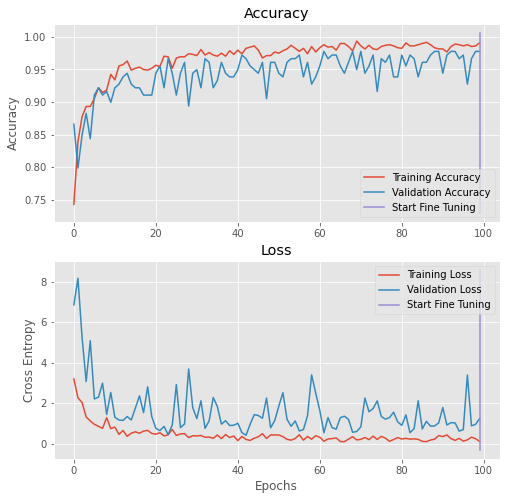

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 4.2829 - accuracy: 0.8984

2/5 [===========>..................] - ETA: 2s - loss: 2.4032 - accuracy: 0.9375

3/5 [=================>............] - ETA: 2s - loss: 1.6021 - accuracy: 0.9583

4/5 [=======================>......] - ETA: 1s - loss: 1.3130 - accuracy: 0.9648

5/5 [==============================] - ETA: 0s - loss: 1.2472 - accuracy: 0.9666

5/5 [==============================] - 9s 2s/step - loss: 1.2472 - accuracy: 0.9666


[1.2471939325332642, 0.9666048288345337]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

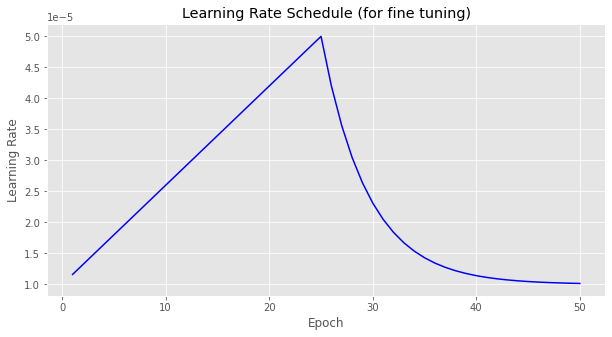

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1077 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5058 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 13s - loss: 0.2529 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 10s - loss: 0.1686 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.1265 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 11s - loss: 0.1012 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 9s - loss: 0.0851 - accuracy: 0.9974 

 7/17 [===========>..................] - ETA: 10s - loss: 0.0922 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.0979 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.0952 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.2116 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.1924 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 6s - loss: 0.1763 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.2184 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.2028 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1893 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1775 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9926

17/17 [==============================] - 22s 1s/step - loss: 0.1687 - accuracy: 0.9926 - val_loss: 1.1844 - val_accuracy: 0.9777



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 5.9045e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 0.0428 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 14s - loss: 0.0285 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 11s - loss: 0.0214 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 10s - loss: 0.0171 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0158 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 11s - loss: 0.0887 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 10s - loss: 0.1056 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 9s - loss: 0.0939 - accuracy: 0.9931 

10/17 [================>.............] - ETA: 8s - loss: 0.0914 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 7s - loss: 0.0833 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.0872 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0807 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.0749 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0699 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0666 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9926

17/17 [==============================] - 22s 1s/step - loss: 0.0633 - accuracy: 0.9926 - val_loss: 1.1130 - val_accuracy: 0.9777



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8217 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 17s - loss: 0.7734 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 14s - loss: 0.5156 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 11s - loss: 0.3868 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 11s - loss: 0.3095 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 10s - loss: 0.2579 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 9s - loss: 0.2517 - accuracy: 0.9888 

 8/17 [=============>................] - ETA: 10s - loss: 0.2344 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 8s - loss: 0.2623 - accuracy: 0.9861 

10/17 [================>.............] - ETA: 8s - loss: 0.2693 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 6s - loss: 0.2448 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 5s - loss: 0.2806 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 4s - loss: 0.2633 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 3s - loss: 0.2445 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2584 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2423 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9870

17/17 [==============================] - 20s 1s/step - loss: 0.2304 - accuracy: 0.9870 - val_loss: 1.0431 - val_accuracy: 0.9777



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 6s - loss: 0.0018 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 12s - loss: 0.0237 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 10s - loss: 0.1628 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.1302 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1088 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 11s - loss: 0.1184 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1575 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.1672 - accuracy: 0.9878

10/17 [================>.............] - ETA: 9s - loss: 0.1505 - accuracy: 0.9891 

11/17 [==================>...........] - ETA: 8s - loss: 0.1369 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 6s - loss: 0.1255 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1204 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1318 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1237 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1160 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9907

17/17 [==============================] - 22s 1s/step - loss: 0.1103 - accuracy: 0.9907 - val_loss: 0.9806 - val_accuracy: 0.9777



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8971 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.4485 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 14s - loss: 0.4643 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.4751 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 14s - loss: 0.5816 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 14s - loss: 0.5013 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 13s - loss: 0.4454 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 12s - loss: 0.3907 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 10s - loss: 0.3473 - accuracy: 0.9826

10/17 [================>.............] - ETA: 9s - loss: 0.3126 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 8s - loss: 0.4043 - accuracy: 0.9815

12/17 [====================>.........] - ETA: 6s - loss: 0.3733 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.4356 - accuracy: 0.9784

14/17 [=======================>......] - ETA: 3s - loss: 0.5204 - accuracy: 0.9754

15/17 [=========================>....] - ETA: 2s - loss: 0.4857 - accuracy: 0.9771

16/17 [===========================>..] - ETA: 1s - loss: 0.4553 - accuracy: 0.9785

17/17 [==============================] - ETA: 0s - loss: 0.4757 - accuracy: 0.9786

17/17 [==============================] - 23s 1s/step - loss: 0.4757 - accuracy: 0.9786 - val_loss: 0.9165 - val_accuracy: 0.9777



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3355 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 22s - loss: 0.1797 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 20s - loss: 0.3273 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 19s - loss: 0.2455 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.1964 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.2097 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.1877 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1642 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1460 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1314 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1194 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1095 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1083 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1425 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1846 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1776 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9889

17/17 [==============================] - 23s 1s/step - loss: 0.2067 - accuracy: 0.9889 - val_loss: 0.8702 - val_accuracy: 0.9777



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 8.6797e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 4.3398e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 5s - loss: 0.0488 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 7s - loss: 0.0741 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 10s - loss: 0.0617 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 10s - loss: 0.0860 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 11s - loss: 0.0737 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 11s - loss: 0.0682 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.0606 - accuracy: 0.9913

10/17 [================>.............] - ETA: 9s - loss: 0.1616 - accuracy: 0.9891 

11/17 [==================>...........] - ETA: 8s - loss: 0.2010 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 6s - loss: 0.2330 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2324 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.2412 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2822 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2894 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9861

17/17 [==============================] - 22s 1s/step - loss: 0.2751 - accuracy: 0.9861 - val_loss: 0.8280 - val_accuracy: 0.9777



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 3.1106e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.1980 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 9s - loss: 0.1320 - accuracy: 0.9948 

 4/17 [======>.......................] - ETA: 10s - loss: 0.0990 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.0793 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 16s - loss: 0.3488 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 15s - loss: 0.3017 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 14s - loss: 0.2640 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.2593 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.2334 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.2122 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.2154 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2091 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1942 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.2012 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1887 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.9898

17/17 [==============================] - 23s 1s/step - loss: 0.2484 - accuracy: 0.9898 - val_loss: 0.7987 - val_accuracy: 0.9777



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 1.2051e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.2306 - accuracy: 0.9766    

 3/17 [====>.........................] - ETA: 19s - loss: 0.2818 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 19s - loss: 0.2113 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.1694 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.1977 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 16s - loss: 0.1694 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.1499 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.2409 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.2276 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.3478 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.3189 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.3060 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.3329 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.3384 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.3172 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.9889

17/17 [==============================] - 23s 1s/step - loss: 0.3016 - accuracy: 0.9889 - val_loss: 0.7766 - val_accuracy: 0.9777



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0882 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0594 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 13s - loss: 0.0396 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 11s - loss: 0.0436 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 13s - loss: 0.0348 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0572 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 15s - loss: 0.0725 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.1868 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.1703 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1783 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1621 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2173 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2006 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.2317 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2163 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2096 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.9861

17/17 [==============================] - 23s 1s/step - loss: 0.2371 - accuracy: 0.9861 - val_loss: 0.7563 - val_accuracy: 0.9832



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 23s - loss: 0.2799 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 25s - loss: 0.2099 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 19s - loss: 0.1797 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.1498 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 15s - loss: 0.1372 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.2160 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.2801 - accuracy: 0.9861

10/17 [================>.............] - ETA: 9s - loss: 0.2521 - accuracy: 0.9875 

11/17 [==================>...........] - ETA: 8s - loss: 0.2292 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 6s - loss: 0.2172 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2005 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.2149 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.2006 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1881 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9898

17/17 [==============================] - 23s 1s/step - loss: 0.1802 - accuracy: 0.9898 - val_loss: 0.7396 - val_accuracy: 0.9832



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3988 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 12s - loss: 0.1994 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 12s - loss: 0.3279 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 10s - loss: 0.3177 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 15s - loss: 0.2541 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.2118 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 15s - loss: 0.1815 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1588 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1412 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1399 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1271 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1704 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1573 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1498 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1920 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1801 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1712 - accuracy: 0.9907 - val_loss: 0.7299 - val_accuracy: 0.9832



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3182 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 8s - loss: 0.1607 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.1161 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.2554 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 20s - loss: 0.2065 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 18s - loss: 0.1991 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 17s - loss: 0.1950 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 15s - loss: 0.1707 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 14s - loss: 0.1517 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.1374 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1606 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1621 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.1982 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.1841 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.1718 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.1611 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9870

17/17 [==============================] - 24s 1s/step - loss: 0.1531 - accuracy: 0.9870 - val_loss: 0.7249 - val_accuracy: 0.9832



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1217 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 12s - loss: 0.2738 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 10s - loss: 0.2881 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 8s - loss: 0.2161 - accuracy: 0.9883 

 5/17 [=======>......................] - ETA: 15s - loss: 0.2274 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.2439 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 15s - loss: 0.4097 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 13s - loss: 0.3590 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.4125 - accuracy: 0.9826

10/17 [================>.............] - ETA: 10s - loss: 0.3814 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 8s - loss: 0.3468 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 6s - loss: 0.3179 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.3115 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.3431 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.3202 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.9870

17/17 [==============================] - 23s 1s/step - loss: 0.2860 - accuracy: 0.9870 - val_loss: 0.7277 - val_accuracy: 0.9832



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 5.4016e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.2892 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 16s - loss: 0.6672 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.5055 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.4320 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 15s - loss: 0.3752 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 14s - loss: 0.3500 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.3062 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.3411 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.3070 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2791 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2558 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2935 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.3631 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.3697 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.3549 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.9824

17/17 [==============================] - 24s 1s/step - loss: 0.3375 - accuracy: 0.9824 - val_loss: 0.7257 - val_accuracy: 0.9832



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1677 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0839 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 11s - loss: 0.0559 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 11s - loss: 0.0419 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.0335 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 15s - loss: 0.0240 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 14s - loss: 0.0210 - accuracy: 0.9980

 9/17 [==============>...............] - ETA: 13s - loss: 0.1206 - accuracy: 0.9948

10/17 [================>.............] - ETA: 10s - loss: 0.1086 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.1312 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1203 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1212 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1125 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1050 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0984 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.1018 - accuracy: 0.9935 - val_loss: 0.7247 - val_accuracy: 0.9832



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4190 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 12s - loss: 0.2095 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.1407 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 19s - loss: 0.2460 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.2008 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 12s - loss: 0.2154 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.1855 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.1727 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1535 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1665 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.1754 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1608 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1670 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1551 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1483 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1410 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9898

17/17 [==============================] - 23s 1s/step - loss: 0.1341 - accuracy: 0.9898 - val_loss: 0.7206 - val_accuracy: 0.9832



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3974 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 17s - loss: 0.1987 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.1325 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.2160 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 18s - loss: 0.3620 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.3766 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 15s - loss: 0.3228 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.2824 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.3271 - accuracy: 0.9861

10/17 [================>.............] - ETA: 9s - loss: 0.2944 - accuracy: 0.9875 

11/17 [==================>...........] - ETA: 7s - loss: 0.2677 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 6s - loss: 0.2541 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.3011 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.2889 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2696 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2592 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.9842

17/17 [==============================] - 23s 1s/step - loss: 0.2587 - accuracy: 0.9842 - val_loss: 0.7178 - val_accuracy: 0.9832



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 5.2154e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 0.0012 - accuracy: 1.0000   

 3/17 [====>.........................] - ETA: 16s - loss: 0.0091 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 18s - loss: 0.0862 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.1013 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.0998 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.0909 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1027 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1216 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1283 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1167 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1351 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.1249 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1160 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1082 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1015 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9870

17/17 [==============================] - 24s 1s/step - loss: 0.1369 - accuracy: 0.9870 - val_loss: 0.7094 - val_accuracy: 0.9832



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.0161 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 21s - loss: 0.0729 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.1614 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 17s - loss: 0.1291 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1076 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.1057 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1787 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.1589 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1430 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1300 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1311 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1373 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1669 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1765 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1752 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9879

17/17 [==============================] - 24s 1s/step - loss: 0.1666 - accuracy: 0.9879 - val_loss: 0.7167 - val_accuracy: 0.9832



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.0868 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 21s - loss: 0.0579 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.0593 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 18s - loss: 0.0909 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.1163 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.1131 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.0989 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 14s - loss: 0.0879 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.0792 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.0912 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.0903 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1128 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1486 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1388 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1301 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9889

17/17 [==============================] - 24s 1s/step - loss: 0.1434 - accuracy: 0.9889 - val_loss: 0.7126 - val_accuracy: 0.9832



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 17s - loss: 9.3132e-10 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 6.2088e-10 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 0.2347 - accuracy: 0.9883    

 5/17 [=======>......................] - ETA: 16s - loss: 0.2360 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.2974 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.2738 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.2494 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.2306 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2075 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2080 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1907 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1760 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1940 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1818 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1799 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9889

17/17 [==============================] - 24s 1s/step - loss: 0.1710 - accuracy: 0.9889 - val_loss: 0.7110 - val_accuracy: 0.9832



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.0576 - accuracy: 0.9766   

 3/17 [====>.........................] - ETA: 16s - loss: 0.3446 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.3151 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 17s - loss: 0.2521 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 14s - loss: 0.4309 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 15s - loss: 0.5114 - accuracy: 0.9754

 8/17 [=============>................] - ETA: 14s - loss: 0.4529 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 12s - loss: 0.4025 - accuracy: 0.9792

10/17 [================>.............] - ETA: 10s - loss: 0.3811 - accuracy: 0.9797

11/17 [==================>...........] - ETA: 9s - loss: 0.3614 - accuracy: 0.9801 

12/17 [====================>.........] - ETA: 7s - loss: 0.3484 - accuracy: 0.9805

13/17 [=====================>........] - ETA: 5s - loss: 0.3216 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 4s - loss: 0.2987 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2788 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.3165 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.9851

17/17 [==============================] - 24s 1s/step - loss: 0.3010 - accuracy: 0.9851 - val_loss: 0.7068 - val_accuracy: 0.9832



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1596 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.0798 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0532 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.0399 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.0319 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 14s - loss: 0.1140 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.1723 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.1508 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.1340 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.1561 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.1886 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 7s - loss: 0.2229 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2650 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.2554 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2384 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2237 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9889

17/17 [==============================] - 22s 1s/step - loss: 0.2127 - accuracy: 0.9889 - val_loss: 0.7036 - val_accuracy: 0.9832



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1553 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 7s - loss: 0.0776 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 7s - loss: 0.0518 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 9s - loss: 0.1338 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.1070 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.0892 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 15s - loss: 0.1422 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.1244 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.1376 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1241 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 8s - loss: 0.1128 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 6s - loss: 0.1034 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0955 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0887 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0829 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0884 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9944

17/17 [==============================] - 25s 1s/step - loss: 0.0964 - accuracy: 0.9944 - val_loss: 0.7049 - val_accuracy: 0.9832



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 4.7961e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 2.3981e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 1.5987e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 12s - loss: 1.1991e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 19s - loss: 9.6105e-05 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 15s - loss: 0.0368 - accuracy: 0.9922    

 7/17 [===========>..................] - ETA: 13s - loss: 0.0315 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.0276 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1117 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1005 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0914 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0837 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1348 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1331 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1267 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1331 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.1266 - accuracy: 0.9916 - val_loss: 0.7032 - val_accuracy: 0.9832



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 19s - loss: 0.1794 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.1381 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 17s - loss: 0.1315 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 19s - loss: 0.1052 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.0877 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.0752 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.0778 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.1134 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1020 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1302 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1293 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 6s - loss: 0.1193 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1108 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1082 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1014 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9916

17/17 [==============================] - 25s 1s/step - loss: 0.0965 - accuracy: 0.9916 - val_loss: 0.6982 - val_accuracy: 0.9832



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 0.2015 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 15s - loss: 0.1343 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 12s - loss: 0.1007 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 13s - loss: 0.1890 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.1670 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1459 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1277 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.1382 - accuracy: 0.9878

10/17 [================>.............] - ETA: 9s - loss: 0.1244 - accuracy: 0.9891 

11/17 [==================>...........] - ETA: 8s - loss: 0.1130 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 7s - loss: 0.1253 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1548 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1438 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1342 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1258 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1198 - accuracy: 0.9907 - val_loss: 0.6944 - val_accuracy: 0.9832



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1509 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.1313 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 21s - loss: 0.0876 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 22s - loss: 0.1001 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.1079 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 15s - loss: 0.0798 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.1364 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1213 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1269 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 7s - loss: 0.1138 - accuracy: 0.9896 

13/17 [=====================>........] - ETA: 6s - loss: 0.1051 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1693 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1665 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1672 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9889

17/17 [==============================] - 25s 1s/step - loss: 0.1590 - accuracy: 0.9889 - val_loss: 0.6957 - val_accuracy: 0.9832



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 18s - loss: 0.0602 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 16s - loss: 0.3487 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 13s - loss: 0.2789 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 18s - loss: 0.2324 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.2268 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.2570 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.2369 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2132 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2316 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2326 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2147 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1994 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1885 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1768 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1684 - accuracy: 0.9898 - val_loss: 0.7011 - val_accuracy: 0.9832



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5119 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 3s - loss: 0.3750 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 18s - loss: 0.2500 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.1875 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 13s - loss: 0.1555 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 15s - loss: 0.1296 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 13s - loss: 0.1111 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.0972 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.0885 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.0796 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.0858 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.0789 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0728 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.0676 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0874 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1250 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1607 - accuracy: 0.9898

17/17 [==============================] - 23s 1s/step - loss: 0.1607 - accuracy: 0.9898 - val_loss: 0.7060 - val_accuracy: 0.9832



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0086 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.0043 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 0.1123 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 16s - loss: 0.1917 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.1789 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.1490 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.1278 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.1118 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 13s - loss: 0.0994 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.1072 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 10s - loss: 0.0974 - accuracy: 0.9943

12/17 [====================>.........] - ETA: 7s - loss: 0.0893 - accuracy: 0.9948 

13/17 [=====================>........] - ETA: 6s - loss: 0.0824 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0765 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0714 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0670 - accuracy: 0.9961

17/17 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9963

17/17 [==============================] - 25s 1s/step - loss: 0.0637 - accuracy: 0.9963 - val_loss: 0.7053 - val_accuracy: 0.9832



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0608 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 5s - loss: 0.0304 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 14s - loss: 0.0791 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.0593 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0474 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0395 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.0373 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0327 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0290 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0262 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.0238 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.0219 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0202 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 4s - loss: 0.1079 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.1007 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0944 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9954

17/17 [==============================] - 24s 1s/step - loss: 0.0898 - accuracy: 0.9954 - val_loss: 0.7054 - val_accuracy: 0.9832



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0877 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 26s - loss: 0.0584 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 20s - loss: 0.0438 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.0351 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 15s - loss: 0.0296 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 14s - loss: 0.0254 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 14s - loss: 0.0222 - accuracy: 0.9980

 9/17 [==============>...............] - ETA: 11s - loss: 0.0197 - accuracy: 0.9983

10/17 [================>.............] - ETA: 10s - loss: 0.0178 - accuracy: 0.9984

11/17 [==================>...........] - ETA: 8s - loss: 0.0162 - accuracy: 0.9986 

12/17 [====================>.........] - ETA: 7s - loss: 0.0244 - accuracy: 0.9974

13/17 [=====================>........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9976

14/17 [=======================>......] - ETA: 4s - loss: 0.0209 - accuracy: 0.9978

15/17 [=========================>....] - ETA: 2s - loss: 0.0196 - accuracy: 0.9979

16/17 [===========================>..] - ETA: 1s - loss: 0.0443 - accuracy: 0.9971

17/17 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9963

17/17 [==============================] - 24s 1s/step - loss: 0.0506 - accuracy: 0.9963 - val_loss: 0.7053 - val_accuracy: 0.9832



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1515 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.0758 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 14s - loss: 0.0505 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.0869 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 13s - loss: 0.0696 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.0592 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.0508 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.0444 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 10s - loss: 0.1088 - accuracy: 0.9931

10/17 [================>.............] - ETA: 8s - loss: 0.1484 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 7s - loss: 0.1349 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.1236 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1141 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.1060 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.1629 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1811 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9889

17/17 [==============================] - 22s 1s/step - loss: 0.1724 - accuracy: 0.9889 - val_loss: 0.7046 - val_accuracy: 0.9832



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2684 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.1718 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 21s - loss: 0.2218 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 16s - loss: 0.2119 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 20s - loss: 0.1695 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 18s - loss: 0.1413 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.1211 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.1059 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.0942 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0848 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0791 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0749 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0700 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0650 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0865 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0814 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1073 - accuracy: 0.9898 - val_loss: 0.7086 - val_accuracy: 0.9832



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0835 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 22s - loss: 0.0753 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.0502 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.0377 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0302 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 18s - loss: 0.0251 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0527 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.0461 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.2057 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2552 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.2534 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.2924 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2718 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2524 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2356 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2208 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9879

17/17 [==============================] - 24s 1s/step - loss: 0.2100 - accuracy: 0.9879 - val_loss: 0.6907 - val_accuracy: 0.9832



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 3.4090e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 0.0068 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0035 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.0032 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 15s - loss: 0.0027 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 16s - loss: 0.0323 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.0297 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.0264 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.0237 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0591 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1029 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0966 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1135 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1059 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.0993 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.0944 - accuracy: 0.9907 - val_loss: 0.6883 - val_accuracy: 0.9832



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 0.6330 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 11s - loss: 0.4745 - accuracy: 0.9609

 3/17 [====>.........................] - ETA: 16s - loss: 0.3520 - accuracy: 0.9688

 4/17 [======>.......................] - ETA: 15s - loss: 0.2858 - accuracy: 0.9727

 5/17 [=======>......................] - ETA: 18s - loss: 0.2561 - accuracy: 0.9750

 6/17 [=========>....................] - ETA: 16s - loss: 0.2134 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 13s - loss: 0.1831 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 15s - loss: 0.3001 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 13s - loss: 0.2668 - accuracy: 0.9826

10/17 [================>.............] - ETA: 11s - loss: 0.2740 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.2491 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.2283 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2528 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2347 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2191 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2058 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9870

17/17 [==============================] - 24s 1s/step - loss: 0.1957 - accuracy: 0.9870 - val_loss: 0.6779 - val_accuracy: 0.9832



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 7.0562e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 20s - loss: 0.1164 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 16s - loss: 0.0895 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.1648 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.1441 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1869 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1635 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.2456 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.2211 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.2288 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.2264 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2090 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1941 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1811 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1698 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.2179 - accuracy: 0.9898 - val_loss: 0.6696 - val_accuracy: 0.9832



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 5.9663e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 3.9775e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 0.0687 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 18s - loss: 0.0550 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 15s - loss: 0.0819 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.1972 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.1726 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1534 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.1400 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1273 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.1168 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.1096 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.1018 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0950 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0891 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9944

17/17 [==============================] - 24s 1s/step - loss: 0.1127 - accuracy: 0.9944 - val_loss: 0.6642 - val_accuracy: 0.9832



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4674 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 7s - loss: 0.2337 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 15s - loss: 0.1558 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.1168 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.0935 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 13s - loss: 0.0779 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 12s - loss: 0.0668 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 12s - loss: 0.0686 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 10s - loss: 0.0610 - accuracy: 0.9965

10/17 [================>.............] - ETA: 9s - loss: 0.0647 - accuracy: 0.9953 

11/17 [==================>...........] - ETA: 7s - loss: 0.0588 - accuracy: 0.9957

12/17 [====================>.........] - ETA: 6s - loss: 0.0566 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 4s - loss: 0.0577 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0887 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0834 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0782 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9926

17/17 [==============================] - 22s 1s/step - loss: 0.1045 - accuracy: 0.9926 - val_loss: 0.6606 - val_accuracy: 0.9832



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 31s - loss: 0.0327 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 21s - loss: 0.0218 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 19s - loss: 0.1328 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.1442 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 18s - loss: 0.1320 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.1699 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.3023 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.3082 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.2774 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.2522 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 6s - loss: 0.2312 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2134 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.2516 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.2954 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.3021 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.9889

17/17 [==============================] - 23s 1s/step - loss: 0.2872 - accuracy: 0.9889 - val_loss: 0.6562 - val_accuracy: 0.9832



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 9.0149e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 4.5080e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 0.0232 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 23s - loss: 0.0174 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 20s - loss: 0.0233 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.0337 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.0289 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0286 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1227 - accuracy: 0.9861

10/17 [================>.............] - ETA: 9s - loss: 0.1481 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 7s - loss: 0.1346 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 7s - loss: 0.1938 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2025 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1880 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1755 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1693 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9879

17/17 [==============================] - 23s 1s/step - loss: 0.1609 - accuracy: 0.9879 - val_loss: 0.6546 - val_accuracy: 0.9832



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0127 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 0.0064 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 0.0101 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 16s - loss: 0.0400 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 18s - loss: 0.0320 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0267 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0229 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 15s - loss: 0.0200 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 14s - loss: 0.0202 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0436 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0396 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0849 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0842 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0785 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0761 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0792 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.0939 - accuracy: 0.9916 - val_loss: 0.6557 - val_accuracy: 0.9832



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 5.3220e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 2.6610e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 10s - loss: 1.7740e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 12s - loss: 0.1049 - accuracy: 0.9922    

 5/17 [=======>......................] - ETA: 16s - loss: 0.1200 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.1000 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 12s - loss: 0.1150 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.1309 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.1163 - accuracy: 0.9913

10/17 [================>.............] - ETA: 8s - loss: 0.1047 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 7s - loss: 0.0952 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.1474 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 4s - loss: 0.1475 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1369 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1278 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1198 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9898

17/17 [==============================] - 22s 1s/step - loss: 0.1451 - accuracy: 0.9898 - val_loss: 0.6550 - val_accuracy: 0.9832



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 1.8626e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 1.2418e-09 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 9.3132e-10 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 13s - loss: 0.0767 - accuracy: 0.9969    

 6/17 [=========>....................] - ETA: 14s - loss: 0.0639 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 12s - loss: 0.0608 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.0532 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 11s - loss: 0.0473 - accuracy: 0.9965

10/17 [================>.............] - ETA: 10s - loss: 0.0426 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 9s - loss: 0.0406 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.1042 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1575 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1745 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1628 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1526 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.2001 - accuracy: 0.9907 - val_loss: 0.6507 - val_accuracy: 0.9832



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.2798 - accuracy: 0.9844    

 3/17 [====>.........................] - ETA: 22s - loss: 0.2691 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 18s - loss: 0.2018 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.1761 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1467 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.1319 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1154 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1026 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0923 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1043 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1414 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.2170 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.2015 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1881 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1763 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.1677 - accuracy: 0.9907 - val_loss: 0.6511 - val_accuracy: 0.9832



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4981 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.2946 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 8s - loss: 0.1964 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 17s - loss: 0.1473 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.2796 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 11s - loss: 0.2330 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.1997 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 11s - loss: 0.1747 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 10s - loss: 0.1559 - accuracy: 0.9931

10/17 [================>.............] - ETA: 8s - loss: 0.1579 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 7s - loss: 0.1441 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.1339 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.2057 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.2056 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1929 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2050 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9870

17/17 [==============================] - 22s 1s/step - loss: 0.1949 - accuracy: 0.9870 - val_loss: 0.6432 - val_accuracy: 0.9832



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2415 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 10s - loss: 0.5974 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 9s - loss: 0.3983 - accuracy: 0.9844 

 4/17 [======>.......................] - ETA: 9s - loss: 0.2987 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 13s - loss: 0.2390 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 11s - loss: 0.1992 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 12s - loss: 0.1707 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 11s - loss: 0.1494 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 10s - loss: 0.1328 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.1368 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.1354 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.1590 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1468 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1363 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1327 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1665 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9898

17/17 [==============================] - 22s 1s/step - loss: 0.1592 - accuracy: 0.9898 - val_loss: 0.6499 - val_accuracy: 0.9832


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

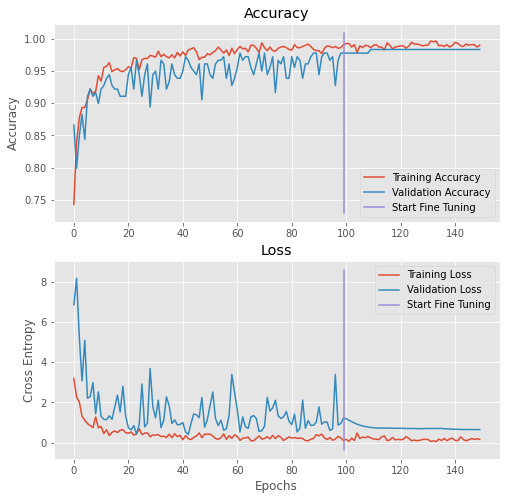

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.8618 - accuracy: 0.9141

2/5 [===========>..................] - ETA: 2s - loss: 1.8632 - accuracy: 0.9453

3/5 [=================>............] - ETA: 2s - loss: 1.2421 - accuracy: 0.9635

4/5 [=======================>......] - ETA: 1s - loss: 1.0285 - accuracy: 0.9688

5/5 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.9703

5/5 [==============================] - 6s 1s/step - loss: 0.9770 - accuracy: 0.9703


[0.9769558906555176, 0.9703153967857361]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9703153988868275
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       158
           1       0.97      0.99      0.98       381

    accuracy                           0.97       539
   macro avg       0.97      0.96      0.96       539
weighted avg       0.97      0.97      0.97       539



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

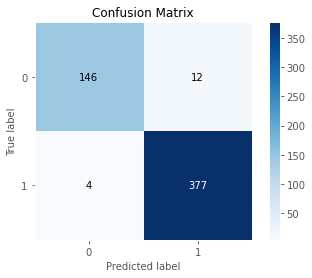

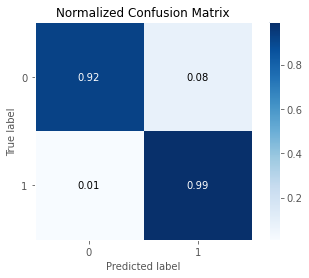

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

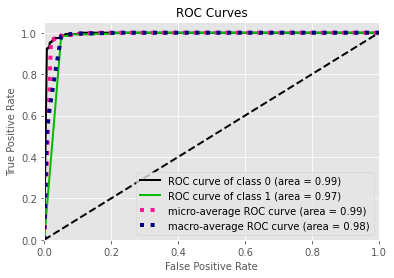

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       158
           1       0.97      0.99      0.98       381

    accuracy                           0.97       539
   macro avg       0.97      0.96      0.96       539
weighted avg       0.97      0.97      0.97       539

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.92      0.99      0.95      0.96      0.91       158
          1       0.97      0.99      0.92      0.98      0.96      0.92       381

avg / total       0.97      0.97      0.94      0.97      0.96      0.92       539

